<a href="https://colab.research.google.com/github/WilliamHO8/iot2/blob/main/2023_23_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3<2.1
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ccdv/pubmed-summarization")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for ccdv/pubmed-summarization contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/pubmed-summarization
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `d

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
from sklearn.model_selection import train_test_split
import random
from datasets import Dataset

# Get the original train split
original_train_dataset = dataset['train']

# Define the desired subsample size
subsample_size = 8000

# Get the indices of the subset
subset_indices = random.sample(range(len(original_train_dataset)), subsample_size)

# Create the subsampled train dataset
subsampled_train_dataset = original_train_dataset.select(subset_indices)


In [ ]:
dataset['train'] = subsampled_train_dataset

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

In [ ]:
device='gpu'
model = BartForConditionalGeneration.from_pretrained(
    'facebook/bart-large-cnn', gradient_checkpointing=True)
tokenizer = BartTokenizer.from_pretrained(
    'facebook/bart-large-cnn')

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

array([[<Axes: title={'center': 'Article Length'}>,
        <Axes: title={'center': 'Abstract Length'}>]], dtype=object)

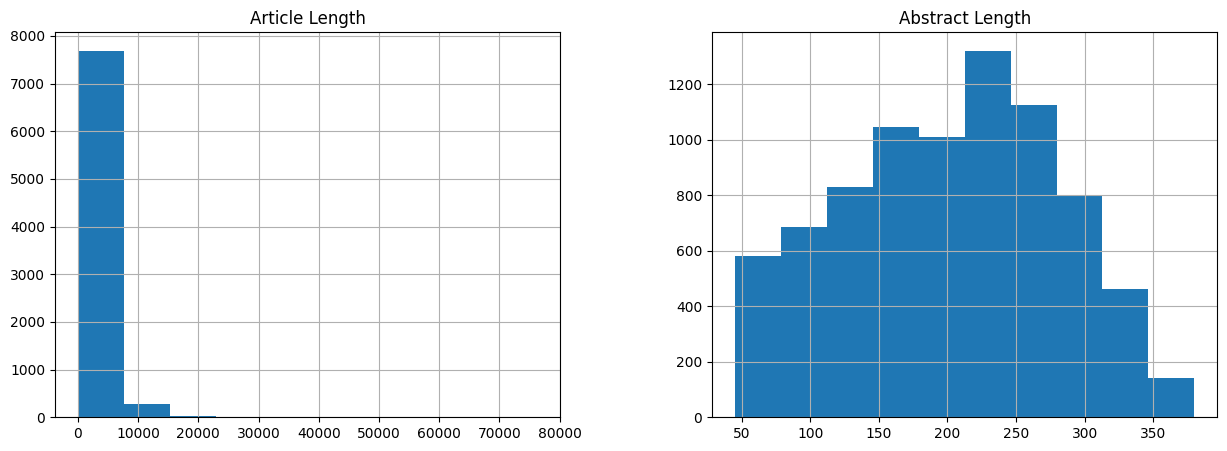

In [ ]:
import pandas as pd

art_len = [len(x['article'].split()) for x in dataset['train']]
abs_len = [len(x['abstract'].split()) for x in dataset['train']]

data = pd.DataFrame([art_len, abs_len]).T
data.columns = ['Article Length', 'Abstract Length']

data.hist(figsize=(15,5))

In [ ]:
def get_feature(batch):
  encodings = tokenizer(batch['article'], text_target=batch['abstract'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
dataset_pt = dataset.map(get_feature, batched=True, num_proc=20)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=20):   0%|          | 0/8000 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/6633 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/6658 [00:00<?, ? examples/s]

In [ ]:
dataset_pt

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['article', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6658
    })
})

In [ ]:
columns = ['input_ids', 'labels', 'attention_mask']
dataset_pt.set_format(type='torch', columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from datasets import load_dataset
from transformers import pipeline

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart-finetuned',
    num_train_epochs=2,
    warmup_steps = 500,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = dataset_pt['train'], eval_dataset = dataset_pt['validation'])

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,2.165300,2.059047


TrainOutput(global_step=500, training_loss=2.3118014183044435, metrics={'train_runtime': 3788.6006, 'train_samples_per_second': 4.223, 'train_steps_per_second': 0.132, 'total_flos': 3.4599141319458816e+16, 'train_loss': 2.3118014183044435, 'epoch': 2.0})

In [ ]:
trainer.evaluate(dataset_pt["test"])

{'eval_loss': 2.0577821731567383,
 'eval_runtime': 376.083,
 'eval_samples_per_second': 17.704,
 'eval_steps_per_second': 8.852,
 'epoch': 2.0}

In [ ]:
trainer.save_model('bart-finetuned-model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [ ]:
!zip bart_finetuned.zip -r bart-finetuned-model/

  adding: bart-finetuned-model/ (stored 0%)
  adding: bart-finetuned-model/generation_config.json (deflated 47%)
  adding: bart-finetuned-model/vocab.json (deflated 68%)
  adding: bart-finetuned-model/merges.txt (deflated 53%)
  adding: bart-finetuned-model/config.json (deflated 62%)
  adding: bart-finetuned-model/tokenizer_config.json (deflated 76%)
  adding: bart-finetuned-model/special_tokens_map.json (deflated 85%)
  adding: bart-finetuned-model/training_args.bin (deflated 51%)
  adding: bart-finetuned-model/model.safetensors (deflated 7%)


In [ ]:
from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import HfApi

model_path = 'bart-finetuned-model'

api = HfApi()
model_repo_name = "WilliamHo/bart-summarization-finetuned"  # Format of Input  <Profile Name > / <Model Repo Name>

#Create Repo in Hugging Face
api.create_repo(repo_id=model_repo_name)

#Upload Model folder from Local to HuggingFace
api.upload_folder(
    folder_path=model_path,
    repo_id=model_repo_name
)

# Publish Model Tokenizer on Hugging Face
tokenizer.push_to_hub(model_repo_name)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/WilliamHo/bart-summarization-finetuned/commit/4719483dd545f0aee7f34d59cdcf2bc7628cc669', commit_message='Upload tokenizer', commit_description='', oid='4719483dd545f0aee7f34d59cdcf2bc7628cc669', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:

pipe = pipeline('summarization', model='bart-finetuned-model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 100}

# custom_dialogue="""
#The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.
# """

custom_dialogue="""
The Notre-Dame fire was a structural fire that broke out in the roof space of Notre-Dame de Paris, a medieval Catholic cathedral in Paris, France, on 15 April 2019. By the time the fire was extinguished, the cathedral's wooden spire (flèche) had collapsed, most of the wooden roof had been destroyed, and the cathedral's upper walls were severely damaged. Extensive damage to the interior was prevented by the vaulted stone ceiling, which largely contained the burning roof as it collapsed. Many works of art and religious relics were moved to safety, but others suffered smoke damage, and some of the exterior art was damaged or destroyed. The cathedral's altar, two pipe organs, and three 13th-century rose windows suffered little or no damage. Three emergency workers were injured, and the site and nearby areas of Paris were contaminated with toxic dust and lead. Investigators in 2020 believed the fire to have been "started by either a cigarette or a short circuit in the electrical system". French president Emmanuel Macron set a five-year deadline to restore the cathedral. This photograph shows the central section of Notre-Dame's spire engulfed in flames.
 """

print(pipe(custom_dialogue, **gen_kwargs))

[{'summary_text': "the fire broke out in the roof space of Notre-Dame de Paris, a medieval Catholic cathedral in Paris, France, on 15 April 2019. By the time the fire was extinguished, the cathedral's wooden spire (flèche) had collapsed, most of the wooden roof had been destroyed, and the cathedral was severely damaged."}]


In [ ]:
!pip install rouge_score
from datasets import load_metric

rouge=load_metric("rouge")

predic=["the Eiffel Tower is the second tallest structure in the world and the second highest free-standing structure in France after the Millau Viaduct. \n the tower is 324 metres (1,063 ft ) in height and is the highest structure in Paris with a diameter of 125 metres (410 ft)."]


refer = ["The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world."]

rouge.compute(predictions=predic,references=refer)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'rouge1': AggregateScore(low=Score(precision=0.5102040816326531, recall=0.5, fmeasure=0.5050505050505051), mid=Score(precision=0.5102040816326531, recall=0.5, fmeasure=0.5050505050505051), high=Score(precision=0.5102040816326531, recall=0.5, fmeasure=0.5050505050505051)),
 'rouge2': AggregateScore(low=Score(precision=0.3125, recall=0.30612244897959184, fmeasure=0.30927835051546393), mid=Score(precision=0.3125, recall=0.30612244897959184, fmeasure=0.30927835051546393), high=Score(precision=0.3125, recall=0.30612244897959184, fmeasure=0.30927835051546393)),
 'rougeL': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.28, fmeasure=0.2828282828282828), mid=Score(precision=0.2857142857142857, recall=0.28, fmeasure=0.2828282828282828), high=Score(precision=0.2857142857142857, recall=0.28, fmeasure=0.2828282828282828)),
 'rougeLsum': AggregateScore(low=Score(precision=0.40816326530612246, recall=0.4, fmeasure=0.4040404040404041), mid=Score(precision=0.40816326530612246, recall=